In [46]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from scipy import stats

### Data-Loading and Pre-Processing

In [2]:
DATASET2_PATH = './dataset_2/' 
DATASET3_PATH = './dataset_3/' 
OUTPUT_SIZE = (256, 256) 

def normalize_slice(slice_2d):
   
    mean = np.mean(slice_2d)
    std = np.std(slice_2d)
    if std == 0:
        return slice_2d - mean
    normalized_slice = (slice_2d - mean) / std
    return normalized_slice

In [3]:
def preprocess_nifti_2d(dwi_path, adc_path, mask_path, output_size):
   
    try:
        # Load all three files
        dwi_nii = nib.load(dwi_path)
        adc_nii = nib.load(adc_path)
        mask_nii = nib.load(mask_path)

        dwi_data = dwi_nii.get_fdata()
        adc_data = adc_nii.get_fdata()
        mask_data = mask_nii.get_fdata()
        
        dwi_data = np.nan_to_num(dwi_data, nan=0.0)
        adc_data = np.nan_to_num(adc_data, nan=0.0)
        mask_data = np.nan_to_num(mask_data, nan=0.0)

        
        if dwi_data.ndim != 2 or adc_data.ndim != 2 or mask_data.ndim != 2:
             print(f"Warning: Expected 2D data for DWI/ADC/Mask triplet starting with {os.path.basename(dwi_path)}. Skipping.")
             return None, None, None, None, None # Return 5 Nones

        
        original_dwi = dwi_data.copy()
        original_adc = adc_data.copy()
        original_mask = mask_data.copy()

        # --- Process Images ---
        # Normalize
        norm_dwi = normalize_slice(dwi_data)
        norm_adc = normalize_slice(adc_data)
        # Resize
        resized_dwi = resize(norm_dwi, output_size, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
        resized_adc = resize(norm_adc, output_size, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
        # Stack into 2 channels
        stacked_image = np.stack([resized_dwi, resized_adc], axis=-1) # Shape (H, W, 2)

        # --- Process Mask ---
        mask_data_uint8 = np.round(mask_data).astype(np.uint8)
        mask_slice_resized = resize(mask_data_uint8, output_size, order=0, preserve_range=True, anti_aliasing=False)
        mask_slice_binary = (mask_slice_resized > 0.5).astype(np.float32)

        # Return originals and processed (stacked image, binary mask)
        return original_dwi, original_adc, original_mask, stacked_image, mask_slice_binary

    except FileNotFoundError:
        # This will be caught by the calling function's check now
        print(f"File not found during processing triplet starting with {os.path.basename(dwi_path)}")
        return None, None, None, None, None
    except Exception as e:
        print(f"Error processing triplet starting with {os.path.basename(dwi_path)}: {e}")
        return None, None, None, None, None

In [4]:
def visualize_sample_2channel(orig_img_ch1, orig_img_ch2, orig_mask,
                              proc_img_ch1, proc_img_ch2, proc_mask, title_prefix):
    
    if orig_img_ch1 is None or proc_img_ch1 is None: return
    plt.figure(figsize=(12, 8)); plt.suptitle(title_prefix)
    # Originals
    plt.subplot(2, 3, 1); plt.imshow(orig_img_ch1, cmap='gray'); plt.title(f'Original DWI ({orig_img_ch1.shape})'); plt.axis('off')
    plt.subplot(2, 3, 2); plt.imshow(orig_img_ch2, cmap='gray'); plt.title(f'Original ADC ({orig_img_ch2.shape})'); plt.axis('off')
    plt.subplot(2, 3, 3); plt.imshow(orig_mask, cmap='jet'); plt.title(f'Original Mask ({orig_mask.shape})'); plt.axis('off')
    # Processed
    plt.subplot(2, 3, 4); plt.imshow(proc_img_ch1, cmap='gray'); plt.title(f'Processed DWI ({proc_img_ch1.shape})'); plt.axis('off')
    plt.subplot(2, 3, 5); plt.imshow(proc_img_ch2, cmap='gray'); plt.title(f'Processed ADC ({proc_img_ch2.shape})'); plt.axis('off')
    plt.subplot(2, 3, 6); plt.imshow(proc_mask, cmap='jet'); plt.title(f'Processed Mask ({proc_mask.shape})'); plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

In [5]:
def load_process_visualize_multimodal_unified(base_path, split_name, output_size, visualize_first=False):
   
    print(f"\n--- Starting {split_name if split_name else 'Dataset'} Processing (DWI & ADC Unified) ---")
    processed_imgs_multichannel = []
    processed_masks_singlechannel = []
    visualized = not visualize_first

    # Define paths
    dwi_folder = os.path.join(base_path, split_name, 'img', 'dwi') if split_name else os.path.join(base_path, 'img', 'dwi')
    adc_folder = os.path.join(base_path, split_name, 'img', 'adc') if split_name else os.path.join(base_path, 'img', 'adc')
    mask_folder = os.path.join(base_path, split_name, 'mask') if split_name else os.path.join(base_path, 'mask')

    dwi_files = sorted(glob.glob(os.path.join(dwi_folder, '*.nii.gz')))
    print(f"Found {len(dwi_files)} DWI files in {dwi_folder}.")

    for dwi_path in tqdm(dwi_files, desc=f"Processing {split_name if split_name else 'Dataset'}"):
        file_id = os.path.basename(dwi_path)
        adc_path = os.path.join(adc_folder, file_id)
        mask_path = os.path.join(mask_folder, file_id)

      
        if not (os.path.exists(adc_path) and os.path.exists(mask_path)):
            continue

        # Call the unified preprocessing function
        orig_dwi, orig_adc, orig_mask, proc_stacked_img, proc_mask = \
            preprocess_nifti_2d(dwi_path, adc_path, mask_path, output_size)

        # Ensure all components processed successfully
        if proc_stacked_img is not None and proc_mask is not None:
            processed_imgs_multichannel.append(proc_stacked_img) # Already stacked (H, W, 2)
            processed_masks_singlechannel.append(proc_mask)     # Single channel (H, W)

            # Visualize the first complete triplet if requested
            if not visualized:
                viz_title = f"{split_name if split_name else 'Dataset'} Sample: {file_id}"
                # Extract channels from processed stacked image for visualization
                proc_dwi_viz = proc_stacked_img[:, :, 0]
                proc_adc_viz = proc_stacked_img[:, :, 1]
                visualize_sample_2channel(orig_dwi, orig_adc, orig_mask,
                                          proc_dwi_viz, proc_adc_viz, proc_mask, viz_title)
                visualized = True

    print(f"{split_name if split_name else 'Dataset'} processing complete. Processed {len(processed_imgs_multichannel)} valid image triplets.")
    return processed_imgs_multichannel, processed_masks_singlechannel


--- Starting Dataset Processing (DWI & ADC Unified) ---
Found 1504 DWI files in ./dataset_2/img/dwi.


Processing Dataset:   0%|          | 0/1504 [00:00<?, ?it/s]

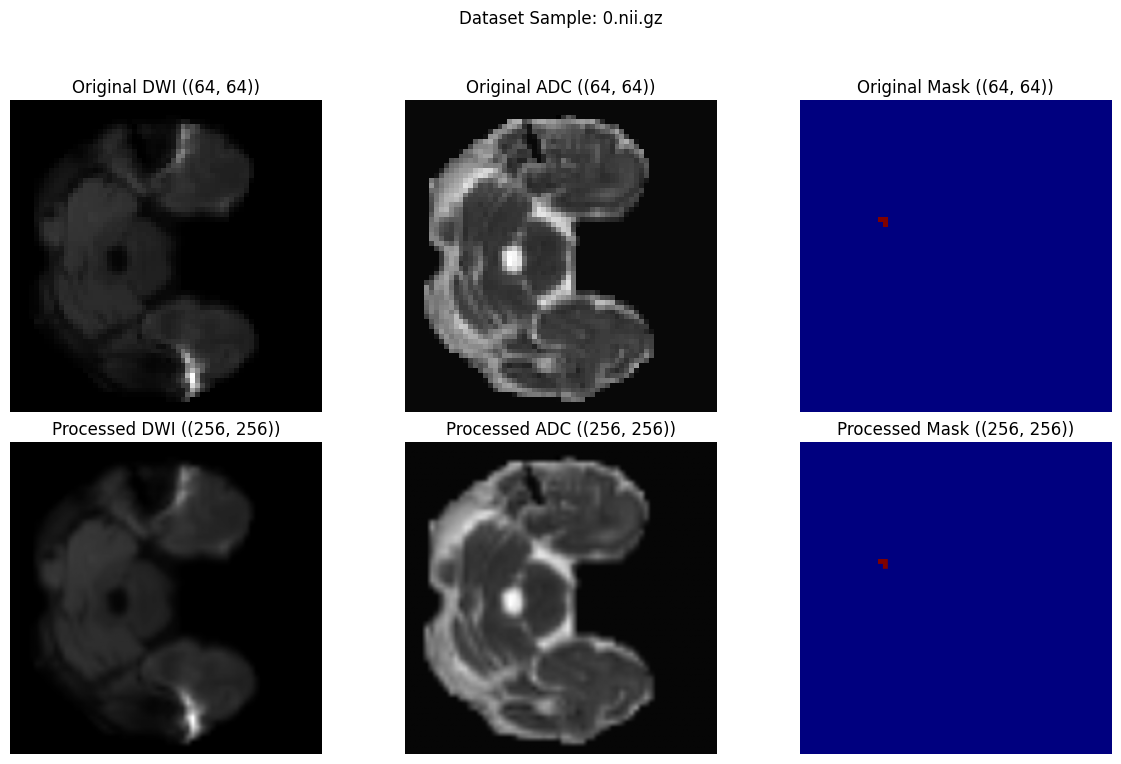

Processing Dataset: 100%|██████████| 1504/1504 [00:10<00:00, 140.05it/s]


Dataset processing complete. Processed 1504 valid image triplets.

--- Starting train Processing (DWI & ADC Unified) ---
Found 950 DWI files in ./dataset_3/train/img/dwi.


Processing train:   0%|          | 0/950 [00:00<?, ?it/s]

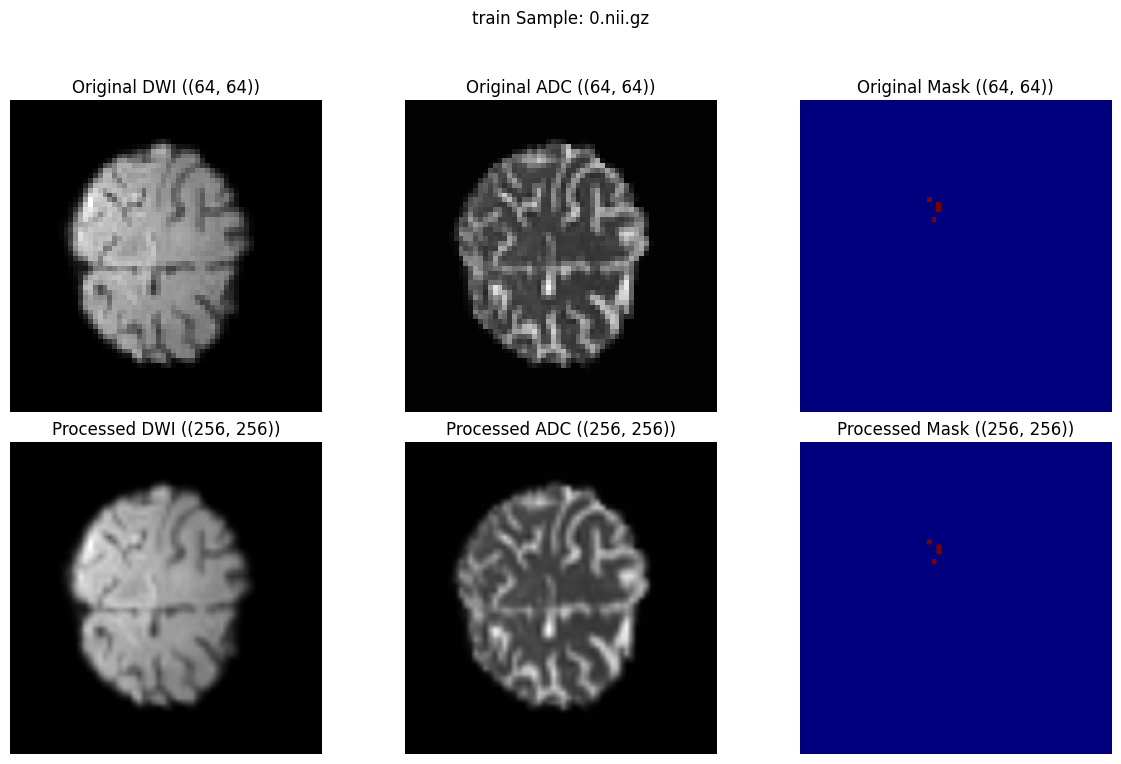

Processing train: 100%|██████████| 950/950 [00:06<00:00, 146.64it/s]


train processing complete. Processed 950 valid image triplets.

--- Starting test Processing (DWI & ADC Unified) ---
Found 407 DWI files in ./dataset_3/test/img/dwi.


Processing test: 100%|██████████| 407/407 [00:02<00:00, 150.95it/s]


test processing complete. Processed 407 valid image triplets.

--- Preprocessing Summary (DWI & ADC channels - Unified Function Corrected) ---
X_source (Dataset 2): (1504, 256, 256, 2)
y_source (Dataset 2): (1504, 256, 256, 1)
X_target_train (Dataset 3): (950, 256, 256, 2)
y_target_train (Dataset 3): (950, 256, 256, 1)
X_target_test (Dataset 3): (407, 256, 256, 2)
y_target_test (Dataset 3): (407, 256, 256, 1)


In [6]:
# 1. Dataset 2
d2_imgs, d2_masks = load_process_visualize_multimodal_unified(
    DATASET2_PATH, split_name=None, output_size=OUTPUT_SIZE, visualize_first=True
)

# 2. Dataset 3 Train
d3_train_imgs, d3_train_masks = load_process_visualize_multimodal_unified(
    DATASET3_PATH, split_name='train', output_size=OUTPUT_SIZE, visualize_first=True
)

# 3. Dataset 3 Test
d3_test_imgs, d3_test_masks = load_process_visualize_multimodal_unified(
    DATASET3_PATH, split_name='test', output_size=OUTPUT_SIZE, visualize_first=False
)


X_source = np.array(d2_imgs)
y_source = np.array(d2_masks)
X_target_train = np.array(d3_train_imgs)
y_target_train = np.array(d3_train_masks)
X_target_test = np.array(d3_test_imgs)
y_target_test = np.array(d3_test_masks)

# Add channel dimension ONLY to masks
if y_source.size > 0: y_source = np.expand_dims(y_source, axis=-1)
if y_target_train.size > 0: y_target_train = np.expand_dims(y_target_train, axis=-1)
if y_target_test.size > 0: y_target_test = np.expand_dims(y_target_test, axis=-1)

# --- Final Shapes ---
print(f"\n--- Preprocessing Summary (DWI & ADC channels - Unified Function Corrected) ---")
print(f"X_source (Dataset 2): {X_source.shape if X_source.size > 0 else 'Empty'}")
print(f"y_source (Dataset 2): {y_source.shape if y_source.size > 0 else 'Empty'}")
print(f"X_target_train (Dataset 3): {X_target_train.shape if X_target_train.size > 0 else 'Empty'}")
print(f"y_target_train (Dataset 3): {y_target_train.shape if y_target_train.size > 0 else 'Empty'}")
print(f"X_target_test (Dataset 3): {X_target_test.shape if X_target_test.size > 0 else 'Empty'}")
print(f"y_target_test (Dataset 3): {y_target_test.shape if y_target_test.size > 0 else 'Empty'}")

### Part (a)

In [7]:
#U-Net Model Definition (Adapted from milesial/Pytorch-UNet)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64 * factor, bilinear) # Corrected output channels for Up4
        self.outc = OutConv(64 * factor, n_classes) # Corrected input channels for OutConv


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [8]:
def numpy_to_pytorch_tensors(images_np, masks_np):
    
    #Converts NumPy image and mask arrays (N, H, W, C) to PyTorch tensors (N, C, H, W).
   
    if images_np.size == 0 or masks_np.size == 0:
        print("Warning: Input NumPy arrays are empty.")
        
        return torch.empty((0, images_np.shape[-1], images_np.shape[1], images_np.shape[2]), dtype=torch.float32), \
               torch.empty((0, masks_np.shape[-1], masks_np.shape[1], masks_np.shape[2]), dtype=torch.float32)

   
    images_tensor = torch.from_numpy(images_np)
    masks_tensor = torch.from_numpy(masks_np)

    # Permute dimensions to (N, C, H, W) and set dtype to float
    # Images: (N, H, W, 2) -> (N, 2, H, W)
    images_tensor = images_tensor.permute(0, 3, 1, 2).float()
    # Masks: (N, H, W, 1) -> (N, 1, H, W)
    masks_tensor = masks_tensor.permute(0, 3, 1, 2).float()

    return images_tensor, masks_tensor

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

BATCH_SIZE = 16 
EPOCHS = 5    
LEARNING_RATE = 1e-4
VAL_PERCENT = 0.1 
EARLY_STOPPING_PATIENCE = 5

Using device: cpu


In [10]:
def dice_coeff_metric(pred_mask_prob, target_mask, smooth=1e-6):
    
    # Flatten label and prediction tensors
    pred_mask_flat = pred_mask_prob.view(-1)
    target_mask_flat = target_mask.view(-1)

    intersection = (pred_mask_flat * target_mask_flat).sum()
    dice = (2. * intersection + smooth) / (pred_mask_flat.sum() + target_mask_flat.sum() + smooth)
    return dice

def dice_loss(pred_mask_logits, target_mask, smooth=1e-6):
   
    pred_mask_prob = torch.sigmoid(pred_mask_logits) # Convert logits to probabilities
    return 1 - dice_coeff_metric(pred_mask_prob, target_mask, smooth)

def combined_loss_pytorch(pred_mask_logits, target_mask, bce_weight=0.5):
    
    # BCE Loss (more numerically stable with logits)
    bce = nn.BCEWithLogitsLoss()
    bce_component = bce(pred_mask_logits, target_mask)

    # Dice Loss
    dice_component = dice_loss(pred_mask_logits, target_mask)

    return (bce_weight * bce_component) + ((1 - bce_weight) * dice_component)

In [11]:
X_source_tensor, y_source_tensor = numpy_to_pytorch_tensors(X_source[:10], y_source[:10])

X_target_test_tensor, y_target_test_tensor = numpy_to_pytorch_tensors(X_target_test[0:5], y_target_test[0:5])

print(f"Source tensor shapes: Images {X_source_tensor.shape}, Masks {y_source_tensor.shape}")
print(f"Target test tensor shapes: Images {X_target_test_tensor.shape}, Masks {y_target_test_tensor.shape}")



Source tensor shapes: Images torch.Size([10, 2, 256, 256]), Masks torch.Size([10, 1, 256, 256])
Target test tensor shapes: Images torch.Size([5, 2, 256, 256]), Masks torch.Size([5, 1, 256, 256])


In [12]:
dataset_source = TensorDataset(X_source_tensor, y_source_tensor)
n_val = int(len(dataset_source) * VAL_PERCENT); n_train = len(dataset_source) - n_val
train_set, val_set = random_split(dataset_source, [n_train, n_val], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()//2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2, pin_memory=True)
print(f"Source data split: {n_train} training, {n_val} validation samples.")

Source data split: 9 training, 1 validation samples.


In [13]:
input_channels = X_source_tensor.shape[1] # Get C from (N, C, H, W)
baseline_model_pt = UNet(n_channels=input_channels, n_classes=1).to(device)
optimizer = optim.Adam(baseline_model_pt.parameters(), lr=LEARNING_RATE)
criterion = combined_loss_pytorch

# 6. Training Loop
print("\n--- Training Baseline Model (PyTorch) on Dataset 2 ---")
best_val_loss = float('inf'); patience_counter = 0
train_losses, val_losses, train_dices, val_dices = [], [], [], []

for epoch in range(EPOCHS):
    baseline_model_pt.train()
    running_loss = 0.0; running_dice = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    for i, (images, masks) in enumerate(progress_bar):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad(); outputs = baseline_model_pt(images)
        loss = criterion(outputs, masks); loss.backward(); optimizer.step()
        running_loss += loss.item()
        with torch.no_grad():
             probs = torch.sigmoid(outputs)
             dice_metric = dice_coeff_metric((probs > 0.5).float(), masks)
        running_dice += dice_metric.item()
        progress_bar.set_postfix({'loss': running_loss / (i + 1), 'dice': running_dice / (i + 1)})
    epoch_train_loss = running_loss / len(train_loader); epoch_train_dice = running_dice / len(train_loader)
    train_losses.append(epoch_train_loss); train_dices.append(epoch_train_dice)

    # Validation
    baseline_model_pt.eval(); val_loss = 0.0; val_dice = 0.0
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
        for i, (images, masks) in enumerate(val_progress_bar):
            images, masks = images.to(device), masks.to(device)
            outputs = baseline_model_pt(images); loss = criterion(outputs, masks)
            val_loss += loss.item(); probs = torch.sigmoid(outputs)
            dice_metric = dice_coeff_metric((probs > 0.5).float(), masks)
            val_dice += dice_metric.item()
            val_progress_bar.set_postfix({'val_loss': val_loss / (i + 1), 'val_dice': val_dice / (i + 1)})
    epoch_val_loss = val_loss / len(val_loader); epoch_val_dice = val_dice / len(val_loader)
    val_losses.append(epoch_val_loss); val_dices.append(epoch_val_dice)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Train Dice: {epoch_train_dice:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Dice: {epoch_val_dice:.4f}")

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss; patience_counter = 0
        # torch.save(baseline_model_pt.state_dict(), 'baseline_unet_model_best.pth') # Optional: Save best
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            # baseline_model_pt.load_state_dict(torch.load('baseline_unet_model_best.pth')) # Optional: Load best
            break


--- Training Baseline Model (PyTorch) on Dataset 2 ---


Epoch 1/5 [Train]:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 - Train Loss: 0.8543, Train Dice: 0.0088 | Val Loss: 0.8387, Val Dice: 0.0350


Epoch 2/5 - Train Loss: 0.8232, Train Dice: 0.0447 | Val Loss: 0.8380, Val Dice: 0.0350


Epoch 3/5 - Train Loss: 0.8011, Train Dice: 0.0722 | Val Loss: 0.8372, Val Dice: 0.0350


Epoch 4/5 - Train Loss: 0.7838, Train Dice: 0.1088 | Val Loss: 0.8365, Val Dice: 0.0350


Epoch 5/5 - Train Loss: 0.7690, Train Dice: 0.1311 | Val Loss: 0.8356, Val Dice: 0.0352


In [14]:
MODEL_SAVE_PATH = "part_a_unet_model_q2" 

print(f"\n--- Saving Model ---")

torch.save(baseline_model_pt.state_dict(), MODEL_SAVE_PATH)
print(f"Model state_dict saved to: {MODEL_SAVE_PATH}")


print("\n--- Verifying Model Loading ---")


print("Creating a new model instance...")

try:
    # Use the shape of the tensor the original model was trained on
    input_channels = X_source_tensor.shape[1] # Should be 2
except NameError:
    print("Warning: X_source_tensor not found, assuming 2 input channels.")
    input_channels = 2 # Manually set to 2 if variable not available

new_model = UNet(n_channels=input_channels, n_classes=1, bilinear=True).to(device) # Corrected n_channels


print(f"Loading state_dict from: {MODEL_SAVE_PATH}")
new_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
#print("State_dict loaded successfully.")


new_model.eval()
print('done')


--- Saving Model ---
Model state_dict saved to: part_a_unet_model_q2

--- Verifying Model Loading ---
Creating a new model instance...
Loading state_dict from: part_a_unet_model_q2
done


In [15]:
print("\n--- Evaluating Baseline Model (PyTorch) on Dataset 3 Test Set ---")
if X_target_test_tensor.shape[0] == 0:
    print("Error: Target test data is empty. Cannot evaluate.")
    baseline_dice_score_pt = 0.0
else:
    test_set = TensorDataset(X_target_test_tensor, y_target_test_tensor)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    print(f"Test set size: {len(test_set)}")

    baseline_model_pt.eval()
    test_dice_scores = []
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating on Test Set"):
            images, masks = images.to(device), masks.to(device)
            outputs = baseline_model_pt(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            for i in range(images.size(0)):
                 dice_score = dice_coeff_metric(preds[i], masks[i])
                 test_dice_scores.append(dice_score.item())

    if test_dice_scores:
        baseline_dice_score_pt = np.mean(test_dice_scores)
    else:
        print("\nNo valid samples found in the test set to calculate Dice score.")
        baseline_dice_score_pt = 0.0

print(f"\nBaseline Model Dice Score on Dataset 3 Test: {baseline_dice_score_pt:.4f}")


--- Evaluating Baseline Model (PyTorch) on Dataset 3 Test Set ---
Test set size: 5


Evaluating on Test Set: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


Baseline Model Dice Score on Dataset 3 Test: 0.0303


### Part (b)

##### Supervised Domain Adaptation: Fine-tuning

In [ ]:
FINETUNE_LR = 1e-5 # Use a lower learning rate for fine-tuning
FINETUNE_EPOCHS = 5 # Adjust epochs for fine-tuning
FINETUNE_MODEL_SAVE_PATH = 'finetuned_unet_model_statedict.pth'
MODEL_SAVE_PATH = "part_a_unet_model_q2"

X_target_train_tensor, y_target_train_tensor = numpy_to_pytorch_tensors(X_target_train, y_target_train)
print("\n--- Loading Baseline Model for Fine-tuning ---")
finetune_model = UNet(n_channels=input_channels, n_classes=1, bilinear=True).to(device) # Must match original architecture

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"Error: Baseline model weights not found at {MODEL_SAVE_PATH}. Cannot fine-tune.")
    exit()

try:
    finetune_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    print(f"Loaded baseline weights from {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Error loading baseline weights: {e}")
    exit()


if X_target_train_tensor.shape[0] > 0:
    target_train_dataset = TensorDataset(X_target_train_tensor, y_target_train_tensor)
    # No validation split needed here unless you want to monitor fine-tuning progress more closely
    target_train_loader = DataLoader(target_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True) # Use num_workers=0 for stability
    print(f"Created DataLoader for Dataset 3 Train ({len(target_train_dataset)} samples).")
else:
    print("Error: Dataset 3 training data is empty. Cannot fine-tune.")
    exit()   


--- Loading Baseline Model for Fine-tuning ---
Loaded baseline weights from part_a_unet_model_q2
Created DataLoader for Dataset 3 Train (10 samples).


In [27]:
optimizer_ft = optim.Adam(finetune_model.parameters(), lr=FINETUNE_LR)
criterion_ft = combined_loss_pytorch # Can use the same combined loss

# --- Fine-tuning Loop ---
print(f"\n--- Fine-tuning on Dataset 3 Train ({FINETUNE_EPOCHS} epochs, LR={FINETUNE_LR}) ---")
finetune_train_losses = []
finetune_train_dices = []

for epoch in range(FINETUNE_EPOCHS):
    finetune_model.train()
    running_loss = 0.0
    running_dice = 0.0
    progress_bar = tqdm(target_train_loader, desc=f"Epoch {epoch+1}/{FINETUNE_EPOCHS} [Fine-tune]", leave=False)

    for i, (images, masks) in enumerate(progress_bar):
        images, masks = images.to(device), masks.to(device)
        optimizer_ft.zero_grad()
        outputs = finetune_model(images)
        loss = criterion_ft(outputs, masks)
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item()
        with torch.no_grad():
             probs = torch.sigmoid(outputs)
             dice_metric = dice_coeff_metric((probs > 0.5).float(), masks)
        running_dice += dice_metric.item()
        progress_bar.set_postfix({'loss': running_loss / (i + 1), 'dice': running_dice / (i + 1)})

    epoch_train_loss = running_loss / len(target_train_loader)
    epoch_train_dice = running_dice / len(target_train_loader)
    finetune_train_losses.append(epoch_train_loss)
    finetune_train_dices.append(epoch_train_dice)
    print(f"Epoch {epoch+1}/{FINETUNE_EPOCHS} - Fine-tune Loss: {epoch_train_loss:.4f}, Fine-tune Dice: {epoch_train_dice:.4f}")

# --- Save Fine-tuned Model ---
torch.save(finetune_model.state_dict(), FINETUNE_MODEL_SAVE_PATH)
print(f"Fine-tuned model state_dict saved to: {FINETUNE_MODEL_SAVE_PATH}")

# --- Evaluate Fine-tuned Model on Dataset 3 Test Set ---
print("\n--- Evaluating Fine-tuned Model on Dataset 3 Test Set ---")
if X_target_test_tensor.shape[0] == 0:
    print("Error: Target test data is empty. Cannot evaluate.")
    finetuned_dice_score_pt = 0.0
else:
    test_set = TensorDataset(X_target_test_tensor, y_target_test_tensor)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True) # Use num_workers=0

    finetune_model.eval() # Set model to evaluation mode
    test_dice_scores_ft = []
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating Fine-tuned Model"):
            images, masks = images.to(device), masks.to(device)
            outputs = finetune_model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            for i in range(images.size(0)):
                 dice_score = dice_coeff_metric(preds[i], masks[i])
                 test_dice_scores_ft.append(dice_score.item())

    if test_dice_scores_ft:
        finetuned_dice_score_pt = np.mean(test_dice_scores_ft)
    else:
        print("\nNo valid test samples found for fine-tuned model evaluation.")
        finetuned_dice_score_pt = 0.0

print(f"\nFine-tuned Model Dice Score on Dataset 3 Test: {finetuned_dice_score_pt:.4f}")


--- Fine-tuning on Dataset 3 Train (5 epochs, LR=1e-05) ---


Epoch 1/5 - Fine-tune Loss: 0.7637, Fine-tune Dice: 0.1008


Epoch 2/5 - Fine-tune Loss: 0.7573, Fine-tune Dice: 0.1359


Epoch 3/5 - Fine-tune Loss: 0.7526, Fine-tune Dice: 0.1701


Epoch 4/5 - Fine-tune Loss: 0.7486, Fine-tune Dice: 0.1987


Epoch 5/5 - Fine-tune Loss: 0.7450, Fine-tune Dice: 0.2249
Fine-tuned model state_dict saved to: finetuned_unet_model_statedict.pth

--- Evaluating Fine-tuned Model on Dataset 3 Test Set ---


Evaluating Fine-tuned Model: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Fine-tuned Model Dice Score on Dataset 3 Test: 0.0301


#### Unsupervised Domain Adaptation: Pseudo-Labeling

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Subset
CONFIDENCE_THRESHOLD = 0.90 # Pixels predicted > this or < (1-this) are considered confident
PSEUDO_LABEL_EPOCHS = 5         
PSEUDO_LABEL_LR = 1e-5       # Learning rate for fine-tuning
PSEUDO_MODEL_SAVE_PATH = 'pseudolabel_unet_model_statedict.pth'

print("\n--- Loading Baseline Model for Pseudo-Labeling ---")
pseudo_model = UNet(n_channels=input_channels, n_classes=1, bilinear=True).to(device)

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"Error: Baseline model weights not found at {MODEL_SAVE_PATH}.")
    exit()
try:
    pseudo_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    print(f"Loaded baseline weights from {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Error loading baseline weights: {e}")
    exit()


print("\n--- Generating Pseudo-Labels on Dataset 3 Train ---")
pseudo_model.eval() # Set to evaluation mode
target_train_images_only_dataset = TensorDataset(X_target_train_tensor) # Dataset with only images
target_train_images_loader = DataLoader(target_train_images_only_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

generated_pseudo_masks = []
with torch.no_grad():
    for (images,) in tqdm(target_train_images_loader, desc="Generating Pseudo-Labels"):
        images = images.to(device)
        outputs = pseudo_model(images)
        probs = torch.sigmoid(outputs) # Get probabilities

        # Create pseudo-masks based on confidence
        # Use a special value (e.g., -1) for uncertain pixels
        pseudo_mask_batch = torch.full_like(probs, -1.0) # Initialize with ignore index
        pseudo_mask_batch[probs > CONFIDENCE_THRESHOLD] = 1.0
        pseudo_mask_batch[probs < (1.0 - CONFIDENCE_THRESHOLD)] = 0.0

        generated_pseudo_masks.append(pseudo_mask_batch.cpu()) # Move back to CPU

# Concatenate all pseudo-masks
y_target_pseudo_tensor = torch.cat(generated_pseudo_masks, dim=0)
print(f"Generated pseudo-masks shape: {y_target_pseudo_tensor.shape}")

# Calculate percentage of confident pixels (optional info)
confident_pixels = (y_target_pseudo_tensor != -1.0).float().sum()
total_pixels = y_target_pseudo_tensor.nelement() # Total number of elements
confidence_ratio = confident_pixels / total_pixels
print(f"Confidence Ratio (pixels > {CONFIDENCE_THRESHOLD} or < {1-CONFIDENCE_THRESHOLD:.2f}): {confidence_ratio:.4f}")

if confidence_ratio < 0.01: # Add a check if very few pixels are confident
    print("Warning: Very low confidence ratio. Pseudo-labeling might not be effective.")

# Create Combined Dataset ---
# We need to filter out samples where the pseudo-mask has no confident pixels (all -1)
# Or modify the loss to ignore -1

# Create datasets
source_dataset_pl = TensorDataset(X_source_tensor, y_source_tensor)
# Combine target images with their generated pseudo-labels
target_pseudo_labeled_dataset = TensorDataset(X_target_train_tensor, y_target_pseudo_tensor)

# Combine the source dataset and the pseudo-labeled target dataset
combined_dataset = ConcatDataset([source_dataset_pl, target_pseudo_labeled_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

print(f"Created combined dataset with {len(combined_dataset)} samples.")

# Modify Loss to Ignore Uncertain Pixels ---
def masked_combined_loss(pred_mask_logits, target_mask, bce_weight=0.5):
    """Combines BCEWithLogitsLoss and Dice Loss, ignoring target pixels with value -1."""
    # Create a mask for valid pixels (where target is not -1)
    valid_mask = (target_mask != -1.0).float()

    # --- BCE Component ---
    bce_loss_func = nn.BCEWithLogitsLoss(reduction='none') # Calculate loss per pixel
    bce_pixel_loss = bce_loss_func(pred_mask_logits, target_mask)
    # Apply mask and calculate mean only over valid pixels
    masked_bce_loss = (bce_pixel_loss * valid_mask).sum() / valid_mask.sum().clamp(min=1) # Avoid division by zero

    # --- Dice Component ---
    # Apply sigmoid and mask predictions/targets *before* calculating Dice
    pred_mask_prob = torch.sigmoid(pred_mask_logits)
    # Only consider valid pixels for Dice calculation
    pred_masked = pred_mask_prob * valid_mask
    target_masked = target_mask * valid_mask
    dice_component = 1 - dice_coeff_metric(pred_masked, target_masked) # Use metric function on masked probs/targets

    # Combine losses
    return (bce_weight * masked_bce_loss) + ((1 - bce_weight) * dice_component)


# Fine-tune on Combined Data ---
print(f"\n--- Fine-tuning with Pseudo-Labels ({PSEUDO_LABEL_EPOCHS} epochs, LR={PSEUDO_LABEL_LR}) ---")
# Reset optimizer or create a new one with the lower LR
optimizer_pl = optim.Adam(pseudo_model.parameters(), lr=PSEUDO_LABEL_LR)
criterion_pl = masked_combined_loss # Use the masked loss

# Fine-tuning loop (similar to before, but on combined_loader and using masked_loss)
for epoch in range(PSEUDO_LABEL_EPOCHS):
    pseudo_model.train()
    running_loss = 0.0
    progress_bar = tqdm(combined_loader, desc=f"Epoch {epoch+1}/{PSEUDO_LABEL_EPOCHS} [Pseudo-Label FT]", leave=False)
    for i, (images, masks) in enumerate(progress_bar):
        images, masks = images.to(device), masks.to(device)
        optimizer_pl.zero_grad()
        outputs = pseudo_model(images)
        loss = criterion_pl(outputs, masks) # Use masked loss
        loss.backward()
        optimizer_pl.step()
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': running_loss / (i + 1)})

    epoch_train_loss = running_loss / len(combined_loader)
    print(f"Epoch {epoch+1}/{PSEUDO_LABEL_EPOCHS} - Pseudo-Label Fine-tune Loss: {epoch_train_loss:.4f}")
    # Note: Monitoring Dice during this phase is less straightforward due to ignored pixels

# --- Save Pseudo-Label Model ---
torch.save(pseudo_model.state_dict(), PSEUDO_MODEL_SAVE_PATH)
print(f"Pseudo-label fine-tuned model state_dict saved to: {PSEUDO_MODEL_SAVE_PATH}")

# Evaluate Pseudo-Label Model on Dataset 3 Test Set ---
print("\n--- Evaluating Pseudo-Label Model on Dataset 3 Test Set ---")
if X_target_test_tensor.shape[0] == 0:
    print("Error: Target test data is empty. Cannot evaluate.")
    pseudolabel_dice_score_pt = 0.0
else:
    test_set = TensorDataset(X_target_test_tensor, y_target_test_tensor)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    pseudo_model.eval() # Set model to evaluation mode
    test_dice_scores_pl = []
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating Pseudo-Label Model"):
            images, masks = images.to(device), masks.to(device)
            outputs = pseudo_model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            for i in range(images.size(0)):
                 dice_score = dice_coeff_metric(preds[i], masks[i])
                 test_dice_scores_pl.append(dice_score.item())

    if test_dice_scores_pl:
        pseudolabel_dice_score_pt = np.mean(test_dice_scores_pl)
    else:
        print("\nNo valid test samples found for pseudo-label model evaluation.")
        pseudolabel_dice_score_pt = 0.0

print(f"\nPseudo-Label Model Dice Score on Dataset 3 Test: {pseudolabel_dice_score_pt:.4f}")

# --- Final Comparison (Update with Pseudo-Label) ---
print("\n--- Dice Scores on Dataset 3 Test ---")
# Assuming baseline_dice_score_pt and finetuned_dice_score_pt exist from previous steps
print(f"Baseline:     {baseline_dice_score_pt:.4f}")
print(f"Fine-tuned:   {finetuned_dice_score_pt:.4f}")
print(f"Pseudo-Label: {pseudolabel_dice_score_pt:.4f}")   




--- Loading Baseline Model for Pseudo-Labeling ---
Loaded baseline weights from part_a_unet_model_q2

--- Generating Pseudo-Labels on Dataset 3 Train ---


Generating Pseudo-Labels: 100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


Generated pseudo-masks shape: torch.Size([10, 1, 256, 256])
Confidence Ratio (pixels > 0.95 or < 0.05): 0.0000
Created combined dataset with 20 samples.

--- Fine-tuning with Pseudo-Labels (5 epochs, LR=1e-05) ---


Epoch 1/5 - Pseudo-Label Fine-tune Loss: 0.7638


Epoch 2/5 - Pseudo-Label Fine-tune Loss: 0.7564


Epoch 3/5 - Pseudo-Label Fine-tune Loss: 0.7572


Epoch 4/5 - Pseudo-Label Fine-tune Loss: 0.7536


Epoch 5/5 - Pseudo-Label Fine-tune Loss: 0.7385
Pseudo-label fine-tuned model state_dict saved to: pseudolabel_unet_model_statedict.pth

--- Evaluating Pseudo-Label Model on Dataset 3 Test Set ---


Evaluating Pseudo-Label Model: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Pseudo-Label Model Dice Score on Dataset 3 Test: 0.0200

--- Dice Scores on Dataset 3 Test ---
Baseline:     0.0303
Fine-tuned:   0.0301
Pseudo-Label: 0.0200


### Part (c)

In [ ]:
import torch
import numpy as np
from skimage import measure
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os



def calculate_lesion_stats_per_slice(y_true_slice, y_pred_slice):
  
    # Find connected components (lesions)
    true_labels, num_true_lesions = measure.label(y_true_slice, connectivity=2, return_num=True)
    pred_labels, num_pred_lesions = measure.label(y_pred_slice, connectivity=2, return_num=True)

    if num_true_lesions == 0 and num_pred_lesions == 0:
        return 0, 0, 0 # No lesions in GT or Pred -> TP=0, FP=0, FN=0 (Correctly identifies no lesions)
    elif num_true_lesions == 0 and num_pred_lesions > 0:
        return 0, num_pred_lesions, 0 # No GT lesions, but Pred lesions -> TP=0, FP=all preds, FN=0
    elif num_true_lesions > 0 and num_pred_lesions == 0:
        return 0, 0, num_true_lesions # GT lesions exist, but no Pred lesions -> TP=0, FP=0, FN=all GTs

    
    # TP_gt: Count of ground truth lesions that overlap with *any* predicted lesion.
    # TP_p: Count of predicted lesions that overlap with *any* ground truth lesion.

    gt_lesions_detected = set() # Store indices of detected GT lesions
    pred_lesions_correct = set() # Store indices of correct predicted lesions

    for i in range(1, num_pred_lesions + 1): # Iterate through predicted lesions (label starts from 1)
        pred_lesion_mask = (pred_labels == i)
        # Find unique GT labels this predicted lesion overlaps with
        overlapping_gt_labels = np.unique(true_labels[pred_lesion_mask])
        overlapping_gt_labels = overlapping_gt_labels[overlapping_gt_labels != 0] # Remove background label 0

        if len(overlapping_gt_labels) > 0:
            pred_lesions_correct.add(i) # This predicted lesion is (at least partially) correct
            for gt_label in overlapping_gt_labels:
                gt_lesions_detected.add(gt_label) # Mark these GT lesions as detected

    tp_gt = len(gt_lesions_detected)        # True Positives from GT perspective
    tp_p = len(pred_lesions_correct)        # True Positives from Prediction perspective
    fn = num_true_lesions - tp_gt           # False Negatives (missed GT lesions)
    fp = num_pred_lesions - tp_p            # False Positives (incorrectly predicted lesions)

    return tp_gt, fp, fn

def calculate_aggregate_lesion_metrics(tp_gt_total, fp_total, fn_total):
   
    if (tp_gt_total + fn_total) == 0:
        recall = 1.0 if fn_total == 0 else 0.0 # Handle case with no GT lesions
    else:
        recall = tp_gt_total / (tp_gt_total + fn_total) # Lesion-wise Recall (Accuracy)

   
    if (tp_gt_total + fp_total) == 0:
         precision = 1.0 if fp_total == 0 else 0.0 # Handle case with no predicted lesions
         print('no lesion detected')
    else:
        precision = tp_gt_total / (tp_gt_total + fp_total) # Lesion-wise Precision based on TP_gt

    if (precision + recall) == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return recall, precision, f1_score


# --- Function to Evaluate a Model ---
def evaluate_model_metrics(model, test_loader, device):
    """Evaluates a loaded model on the test set and returns metrics."""
    model.eval()
    total_dice = 0.0
    agg_tp_gt = 0
    agg_fp = 0
    agg_fn = 0
    num_samples = 0

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images) # Assumes model returns logits
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Calculate metrics per batch item
            for i in range(images.size(0)):
                pred_i = preds[i]
                mask_i = masks[i]

                # Dice Score
                dice = dice_coeff_metric(pred_i, mask_i) # Use metric version on binarized pred
                total_dice += dice.item()

                # Lesion-wise Stats
                # Move to CPU and remove channel dim for skimage
                pred_np = pred_i.squeeze().cpu().numpy().astype(np.uint8)
                mask_np = mask_i.squeeze().cpu().numpy().astype(np.uint8)
                tp_gt, fp, fn = calculate_lesion_stats_per_slice(mask_np, pred_np)
                agg_tp_gt += tp_gt
                agg_fp += fp
                agg_fn += fn
                num_samples += 1

    avg_dice = total_dice / num_samples if num_samples > 0 else 0.0
    lesion_recall, lesion_precision, lesion_f1 = calculate_aggregate_lesion_metrics(agg_tp_gt, agg_fp, agg_fn)

    return avg_dice, lesion_f1, lesion_recall # Dice, F1, Accuracy(Recall)

In [ ]:

if X_target_test_tensor.shape[0] == 0:
    print("Error: Target test data tensor is empty. Cannot evaluate.")
    exit()
test_set = TensorDataset(X_target_test_tensor, y_target_test_tensor)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) # Use num_workers=0

# --- Dictionary to store results ---
results = {
    "Baseline": {"Dice": 0.0, "Lesion F1": 0.0, "Lesion Acc (Recall)": 0.0},
    "Fine-tuned": {"Dice": 0.0, "Lesion F1": 0.0, "Lesion Acc (Recall)": 0.0},
    "Pseudo-Label": {"Dice": 0.0, "Lesion F1": 0.0, "Lesion Acc (Recall)": 0.0},
    
}

# --- Evaluate Baseline Model ---
print("\n--- Evaluating Baseline Model ---")
if os.path.exists(MODEL_SAVE_PATH):
    model_to_eval = UNet(n_channels=input_channels, n_classes=1).to(device)
    try:
        model_to_eval.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        dice, f1, recall = evaluate_model_metrics(model_to_eval, test_loader, device)
        results["Baseline"]["Dice"] = dice
        results["Baseline"]["Lesion F1"] = f1
        results["Baseline"]["Lesion Acc (Recall)"] = recall
    except Exception as e:
        print(f"Error loading or evaluating baseline model: {e}")
else:
    print(f"Baseline model file not found: {MODEL_SAVE_PATH}")


# --- Evaluate Fine-tuned Model ---
print("\n--- Evaluating Fine-tuned Model ---")
if os.path.exists(FINETUNE_MODEL_SAVE_PATH):
    model_to_eval = UNet(n_channels=input_channels, n_classes=1).to(device)
    try:
        model_to_eval.load_state_dict(torch.load(FINETUNE_MODEL_SAVE_PATH, map_location=device))
        dice, f1, recall = evaluate_model_metrics(model_to_eval, test_loader, device)
        results["Fine-tuned"]["Dice"] = dice
        results["Fine-tuned"]["Lesion F1"] = f1
        results["Fine-tuned"]["Lesion Acc (Recall)"] = recall
    except Exception as e:
        print(f"Error loading or evaluating fine-tuned model: {e}")
else:
    print(f"Fine-tuned model file not found: {FINETUNE_MODEL_SAVE_PATH}")


# --- Evaluate Pseudo-Label Model ---
print("\n--- Evaluating Pseudo-Label Model ---")
if os.path.exists(PSEUDO_MODEL_SAVE_PATH):
    model_to_eval = UNet(n_channels=input_channels, n_classes=1).to(device)
    try:
        model_to_eval.load_state_dict(torch.load(PSEUDO_MODEL_SAVE_PATH, map_location=device))
        dice, f1, recall = evaluate_model_metrics(model_to_eval, test_loader, device)
        results["Pseudo-Label"]["Dice"] = dice
        results["Pseudo-Label"]["Lesion F1"] = f1
        results["Pseudo-Label"]["Lesion Acc (Recall)"] = recall
    except Exception as e:
        print(f"Error loading or evaluating pseudo-label model: {e}")
else:
    print(f"Pseudo-Label model file not found: {PSEUDO_MODEL_SAVE_PATH}")




--- Evaluating Baseline Model ---


Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]



--- Evaluating Fine-tuned Model ---


Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]



--- Evaluating Pseudo-Label Model ---


Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [45]:
import pandas as pd # Use pandas for nice table formatting (pip install pandas)

# --- Print Results Table ---
print("\n--- Performance Metrics on Dataset 3 Test Set ---")

# Convert results dict to DataFrame
results_df = pd.DataFrame(results).T # Transpose to have models as rows
results_df = results_df[["Dice", "Lesion F1", "Lesion Acc (Recall)"]] # Ensure column order

# Format to 4 decimal places
print(results_df.round(4).to_markdown(numalign="left", stralign="left"))




--- Performance Metrics on Dataset 3 Test Set ---
|              | Dice   | Lesion F1   | Lesion Acc (Recall)   |
|:-------------|:-------|:------------|:----------------------|
| Baseline     | 0.0303 | 0.9231      | 1                     |
| Fine-tuned   | 0.0301 | 0.1791      | 1                     |
| Pseudo-Label | 0.02   | 0.3529      | 1                     |


In [36]:
!pip install pandas
!pip install tabulate

### Part (d)

In [47]:
def calculate_single_lesion_metrics(tp_gt, fp, fn):
    
    if (tp_gt + fn) == 0:
        recall = 1.0 # Correctly identified no lesions
    else:
        recall = tp_gt / (tp_gt + fn)

    # Precision
    if (tp_gt + fp) == 0:
        precision = 1.0 # Correctly predicted no lesions
    else:
        precision = tp_gt / (tp_gt + fp)

    # F1 Score
    if (precision + recall) == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return recall, precision, f1_score


# --- New Evaluation Function for Per-Sample Metrics ---
def evaluate_model_per_sample(model, test_loader, device):
    """Evaluates model and returns lists of per-sample metrics."""
    model.eval()
    all_dice_scores = []
    all_lesion_f1 = []
    all_lesion_recall = [] # Lesion Accuracy

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating Per Sample"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            for i in range(images.size(0)):
                pred_i = preds[i]
                mask_i = masks[i]

                # Dice Score
                dice = dice_coeff_metric(pred_i, mask_i)
                all_dice_scores.append(dice.item())

                # Lesion-wise Stats
                pred_np = pred_i.squeeze().cpu().numpy().astype(np.uint8)
                mask_np = mask_i.squeeze().cpu().numpy().astype(np.uint8)
                tp_gt, fp, fn = calculate_lesion_stats_per_slice(mask_np, pred_np)

                # Calculate per-sample F1 and Recall
                recall, _, f1 = calculate_single_lesion_metrics(tp_gt, fp, fn)
                all_lesion_recall.append(recall)
                all_lesion_f1.append(f1)

    return all_dice_scores, all_lesion_f1, all_lesion_recall

In [48]:
per_sample_results = {}

# --- Evaluate Baseline ---
print("\n--- Getting Per-Sample Metrics for Baseline Model ---")
if os.path.exists(MODEL_SAVE_PATH):
    model_to_eval = UNet(n_channels=input_channels, n_classes=1).to(device)
    try:
        model_to_eval.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        dice, f1, recall = evaluate_model_per_sample(model_to_eval, test_loader, device)
        per_sample_results["Baseline"] = {"Dice": dice, "Lesion F1": f1, "Lesion Recall": recall}
        print(f"Baseline: Avg Dice={np.mean(dice):.4f}, Avg F1={np.mean(f1):.4f}, Avg Recall={np.mean(recall):.4f}")
    except Exception as e:
        print(f"Error evaluating baseline model: {e}")
        per_sample_results["Baseline"] = None # Mark as failed
else:
    print(f"Baseline model file not found: {MODEL_SAVE_PATH}")
    per_sample_results["Baseline"] = None

# --- Evaluate Fine-tuned ---
print("\n--- Getting Per-Sample Metrics for Fine-tuned Model ---")
if os.path.exists(FINETUNE_MODEL_SAVE_PATH):
    model_to_eval = UNet(n_channels=input_channels, n_classes=1).to(device)
    try:
        model_to_eval.load_state_dict(torch.load(FINETUNE_MODEL_SAVE_PATH, map_location=device))
        dice, f1, recall = evaluate_model_per_sample(model_to_eval, test_loader, device)
        per_sample_results["Fine-tuned"] = {"Dice": dice, "Lesion F1": f1, "Lesion Recall": recall}
        print(f"Fine-tuned: Avg Dice={np.mean(dice):.4f}, Avg F1={np.mean(f1):.4f}, Avg Recall={np.mean(recall):.4f}")
    except Exception as e:
        print(f"Error evaluating fine-tuned model: {e}")
        per_sample_results["Fine-tuned"] = None
else:
    print(f"Fine-tuned model file not found: {FINETUNE_MODEL_SAVE_PATH}")
    per_sample_results["Fine-tuned"] = None

# --- Evaluate Pseudo-Label ---
print("\n--- Getting Per-Sample Metrics for Pseudo-Label Model ---")
if os.path.exists(PSEUDO_MODEL_SAVE_PATH):
    model_to_eval = UNet(n_channels=input_channels, n_classes=1).to(device)
    try:
        model_to_eval.load_state_dict(torch.load(PSEUDO_MODEL_SAVE_PATH, map_location=device))
        dice, f1, recall = evaluate_model_per_sample(model_to_eval, test_loader, device)
        per_sample_results["Pseudo-Label"] = {"Dice": dice, "Lesion F1": f1, "Lesion Recall": recall}
        print(f"Pseudo-Label: Avg Dice={np.mean(dice):.4f}, Avg F1={np.mean(f1):.4f}, Avg Recall={np.mean(recall):.4f}")
    except Exception as e:
        print(f"Error evaluating pseudo-label model: {e}")
        per_sample_results["Pseudo-Label"] = None
else:
    print(f"Pseudo-Label model file not found: {PSEUDO_MODEL_SAVE_PATH}")
    per_sample_results["Pseudo-Label"] = None


--- Getting Per-Sample Metrics for Baseline Model ---


Evaluating Per Sample: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Baseline: Avg Dice=0.0303, Avg F1=0.8000, Avg Recall=1.0000

--- Getting Per-Sample Metrics for Fine-tuned Model ---


Evaluating Per Sample: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Fine-tuned: Avg Dice=0.0301, Avg F1=0.1531, Avg Recall=1.0000

--- Getting Per-Sample Metrics for Pseudo-Label Model ---


Evaluating Per Sample: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Pseudo-Label: Avg Dice=0.0200, Avg F1=0.3098, Avg Recall=1.0000


In [49]:
# --- Statistical Testing ---
print("\n--- Statistical Test Results (vs Baseline) ---")

baseline_metrics = per_sample_results.get("Baseline")

# Check if baseline results exist
if baseline_metrics is None:
    print("Baseline model results not available. Cannot perform statistical tests.")
else:
    # Compare Fine-tuned vs Baseline
    finetuned_metrics = per_sample_results.get("Fine-tuned")
    if finetuned_metrics:
        print("\nComparing Fine-tuned vs Baseline:")
        try:
            stat_dice, p_dice = stats.wilcoxon(finetuned_metrics["Dice"], baseline_metrics["Dice"])
            print(f"  Dice Score:       p-value = {p_dice:.4f} {'(Significant p<0.05)' if p_dice < 0.05 else ''}")
        except ValueError as e:
            print(f"  Dice Score:       Could not perform test (possibly identical data or zero differences): {e}")

        try:
            stat_f1, p_f1 = stats.wilcoxon(finetuned_metrics["Lesion F1"], baseline_metrics["Lesion F1"])
            print(f"  Lesion F1 Score:  p-value = {p_f1:.4f} {'(Significant p<0.05)' if p_f1 < 0.05 else ''}")
        except ValueError as e:
            print(f"  Lesion F1 Score:  Could not perform test: {e}")

        try:
            stat_recall, p_recall = stats.wilcoxon(finetuned_metrics["Lesion Recall"], baseline_metrics["Lesion Recall"])
            print(f"  Lesion Recall:    p-value = {p_recall:.4f} {'(Significant p<0.05)' if p_recall < 0.05 else ''}")
        except ValueError as e:
             print(f"  Lesion Recall:    Could not perform test: {e}")
    else:
        print("\nFine-tuned model results not available for comparison.")

    # Compare Pseudo-Label vs Baseline
    pseudolabel_metrics = per_sample_results.get("Pseudo-Label")
    if pseudolabel_metrics:
        print("\nComparing Pseudo-Label vs Baseline:")
        try:
            stat_dice, p_dice = stats.wilcoxon(pseudolabel_metrics["Dice"], baseline_metrics["Dice"])
            print(f"  Dice Score:       p-value = {p_dice:.4f} {'(Significant p<0.05)' if p_dice < 0.05 else ''}")
        except ValueError as e:
            print(f"  Dice Score:       Could not perform test: {e}")

        try:
            stat_f1, p_f1 = stats.wilcoxon(pseudolabel_metrics["Lesion F1"], baseline_metrics["Lesion F1"])
            print(f"  Lesion F1 Score:  p-value = {p_f1:.4f} {'(Significant p<0.05)' if p_f1 < 0.05 else ''}")
        except ValueError as e:
            print(f"  Lesion F1 Score:  Could not perform test: {e}")

        try:
            stat_recall, p_recall = stats.wilcoxon(pseudolabel_metrics["Lesion Recall"], baseline_metrics["Lesion Recall"])
            print(f"  Lesion Recall:    p-value = {p_recall:.4f} {'(Significant p<0.05)' if p_recall < 0.05 else ''}")
        except ValueError as e:
             print(f"  Lesion Recall:    Could not perform test: {e}")
    else:
        print("\nPseudo-Label model results not available for comparison.")

    


--- Statistical Test Results (vs Baseline) ---

Comparing Fine-tuned vs Baseline:
  Dice Score:       p-value = 0.6250 
  Lesion F1 Score:  p-value = 0.1250 
  Lesion Recall:    p-value = 1.0000 

Comparing Pseudo-Label vs Baseline:
  Dice Score:       p-value = 0.6250 
  Lesion F1 Score:  p-value = 0.1250 
  Lesion Recall:    p-value = 1.0000 


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:178: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se
